In [1]:
import os
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
# Colab helper
try:
    from google.colab import files
    COLAB = True
except:
    COLAB = False

# Try common filenames first
candidates = [
    "OnlineRetail.csv", "online_retail_II.csv", "OnlineRetailII.csv",
    "online_retail.csv", "online_retail_ii.csv"
]

df = None
for fname in candidates:
    if os.path.exists(fname):
        df = pd.read_csv(fname, encoding="ISO-8859-1")
        print("Loaded:", fname)
        break

if df is None:
    if COLAB:
        print("No file found in working directory — please upload the CSV (Online Retail dataset).")
        uploaded = files.upload()  # opens a file-picker in Colab
        key = next(iter(uploaded))
        df = pd.read_csv(io.BytesIO(uploaded[key]), encoding="ISO-8859-1")
        print("Loaded uploaded file:", key)
    else:
        raise FileNotFoundError("CSV not found. Place 'OnlineRetail.csv' in the working directory or use Colab upload.")

print("Data shape:", df.shape)
df.head()


Loaded: OnlineRetail.csv
Data shape: (150444, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [2]:
# Preview and basic diagnostics
print("Columns:", df.columns.tolist())
print("\n--- Data types and non-null counts ---")
display(df.info())

print("\n--- Missing values per column ---")
print(df.isnull().sum())

# Show a few rows to inspect real values
display(df.head(8))

# Helpful counts
for col in ["InvoiceNo", "StockCode", "Description", "CustomerID", "Country"]:
    if col in df.columns:
        print(f"{col}: {df[col].nunique():,} unique values")


Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

--- Data types and non-null counts ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150444 entries, 0 to 150443
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    150444 non-null  object 
 1   StockCode    150444 non-null  object 
 2   Description  149846 non-null  object 
 3   Quantity     150444 non-null  int64  
 4   InvoiceDate  150443 non-null  object 
 5   UnitPrice    150443 non-null  float64
 6   CustomerID   103940 non-null  float64
 7   Country      150443 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 9.2+ MB


None


--- Missing values per column ---
InvoiceNo          0
StockCode          0
Description      598
Quantity           0
InvoiceDate        1
UnitPrice          1
CustomerID     46504
Country            1
dtype: int64


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom


InvoiceNo: 7,426 unique values
StockCode: 3,311 unique values
Description: 3,213 unique values
CustomerID: 2,286 unique values
Country: 32 unique values


In [3]:
#Cleaning
# 1) Detect a date column (common names: InvoiceDate, Date)
date_cols = [c for c in df.columns if "date" in c.lower()]
date_col = date_cols[0] if date_cols else None
print("Detected date column:", date_col)

# Convert date to datetime and rename to InvoiceDate if necessary
if date_col:
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    if date_col != "InvoiceDate":
        df = df.rename(columns={date_col: "InvoiceDate"})

# Ensure numeric Quantity and UnitPrice
for c in ["Quantity", "UnitPrice"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Create Sales if possible
if set(["Quantity", "UnitPrice"]).issubset(df.columns):
    df["Sales"] = df["Quantity"] * df["UnitPrice"]

print("Shape before cleaning:", df.shape)

# Drop exact duplicate rows
before = df.shape[0]
df = df.drop_duplicates()
print("Dropped duplicates:", before - df.shape[0])

# Remove cancelled invoices (InvoiceNo starting with 'C') if present
if "InvoiceNo" in df.columns and df["InvoiceNo"].dtype == object:
    before = df.shape[0]
    df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]
    print("Dropped cancellations:", before - df.shape[0])

# Drop rows missing critical columns (InvoiceDate, Quantity, UnitPrice, Sales)
critical = [c for c in ["InvoiceDate", "Quantity", "UnitPrice", "Sales"] if c in df.columns]
before = df.shape[0]
df = df.dropna(subset=critical)
print("Dropped rows missing critical fields:", before - df.shape[0])

# Optional: drop rows missing CustomerID (commonly used for customer-level analysis)
if "CustomerID" in df.columns:
    missing_cust = df["CustomerID"].isnull().sum()
    print("Rows missing CustomerID (will be dropped):", missing_cust)
    df = df.dropna(subset=["CustomerID"])
    # convert to integer (if safe)
    try:
        df["CustomerID"] = df["CustomerID"].astype(int)
    except:
        pass

print("Shape after cleaning:", df.shape)


Detected date column: InvoiceDate
Shape before cleaning: (150444, 9)
Dropped duplicates: 1358
Dropped cancellations: 2736
Dropped rows missing critical fields: 1
Rows missing CustomerID (will be dropped): 46336
Shape after cleaning: (100013, 9)


In [4]:
#Descriptive statistics for Sales, Quantity, UnitPrice
stats_cols = [c for c in ["Sales", "Quantity", "UnitPrice"] if c in df.columns]
summary = []
for col in stats_cols:
    mean = df[col].mean()
    median = df[col].median()
    mode = df[col].mode().iloc[0] if not df[col].mode().empty else np.nan
    std = df[col].std()
    summary.append((col, mean, median, mode, std))
    print(f"{col:10s} → mean: {mean:.4f}, median: {median:.4f}, mode: {mode}, std: {std:.4f}")

# Tabular view using a DataFrame
stats_df = pd.DataFrame(summary, columns=["column", "mean", "median", "mode", "std"])
display(stats_df.set_index("column"))


Sales      → mean: 23.1207, median: 12.6000, mode: 15.0, std: 255.1788
Quantity   → mean: 13.5100, median: 6.0000, mode: 1, std: 239.2275
UnitPrice  → mean: 3.2521, median: 1.9500, mode: 1.25, std: 14.7634


,mean,median,mode,std
column,,,,
Sales,23.120667,12.60,15.00,255.178813
Quantity,13.510044,6.00,1.00,239.227499
UnitPrice,3.252136,1.95,1.25,14.763415


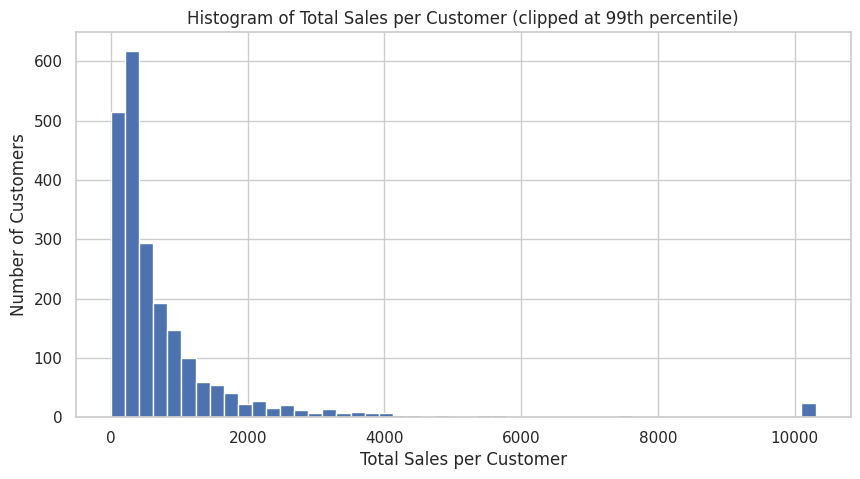

In [5]:
#Histogram: Sales per customer (or per invoice if no CustomerID)
import matplotlib.ticker as mtick

if "CustomerID" in df.columns:
    sales_per_customer = df.groupby("CustomerID")["Sales"].sum()
    clip_val = sales_per_customer.quantile(0.99)  # clip tail
    plt.figure(figsize=(10,5))
    plt.hist(sales_per_customer.clip(upper=clip_val), bins=50)
    plt.title("Histogram of Total Sales per Customer (clipped at 99th percentile)")
    plt.xlabel("Total Sales per Customer")
    plt.ylabel("Number of Customers")
    plt.show()
else:
    sales_per_invoice = df.groupby("InvoiceNo")["Sales"].sum()
    clip_val = sales_per_invoice.quantile(0.99)
    plt.figure(figsize=(10,5))
    plt.hist(sales_per_invoice.clip(upper=clip_val), bins=50)
    plt.title("Histogram of Sales per Invoice (clipped at 99th percentile)")
    plt.xlabel("Sales per Invoice")
    plt.ylabel("Count")
    plt.show()


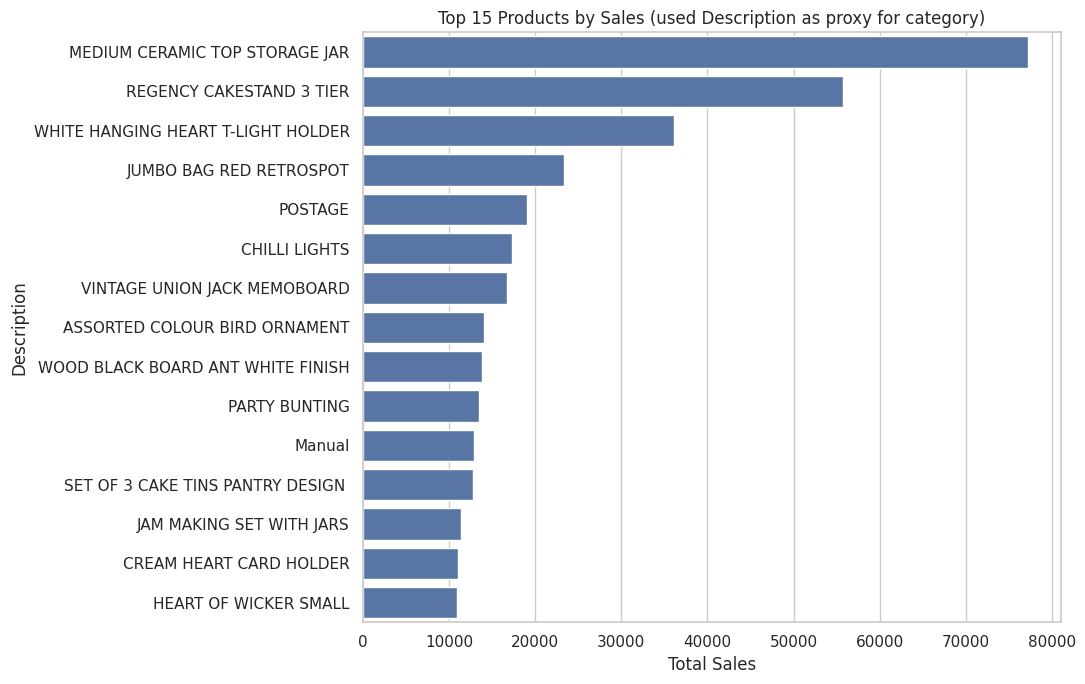

In [8]:
# Bar chart: Sales by product category (or top products if no category)
# Decide which column to use as category
cat_candidates = ["Category", "ProductCategory", "category", "product_category"]
cat_col = next((c for c in cat_candidates if c in df.columns), None)

if cat_col is None:
    # Use Description as a proxy; take the top 15 descriptions by sales
    group_col = "Description"
    title_text = "Top 15 Products by Sales (used Description as proxy for category)"
else:
    group_col = cat_col
    title_text = f"Sales by Category ({cat_col})"

top = df.groupby(group_col)["Sales"].sum().sort_values(ascending=False).head(15)
plt.figure(figsize=(11,7))
sns.barplot(x=top.values, y=top.index)
plt.title(title_text)
plt.xlabel("Total Sales")
plt.ylabel(group_col)
plt.tight_layout()
plt.show()


/tmp/ipython-input-392215528.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df_time["Sales"].resample("M").sum()


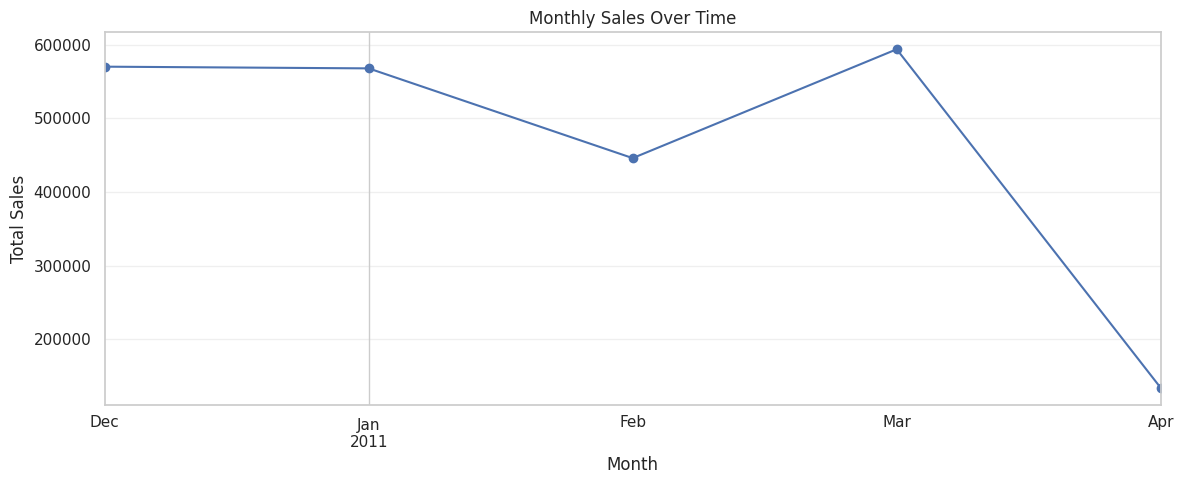

In [7]:
#Line chart: Sales over time (monthly aggregation)
# Make sure InvoiceDate is the index with datetime dtype
if "InvoiceDate" not in df.columns:
    raise RuntimeError("InvoiceDate column not found. Ensure you converted a date column earlier.")

# aggregate monthly
df_time = df.set_index("InvoiceDate")
monthly_sales = df_time["Sales"].resample("M").sum()

plt.figure(figsize=(12,5))
monthly_sales.plot(marker="o")
plt.title("Monthly Sales Over Time")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()
